In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange

In [2]:
os.chdir('../')

In [3]:
%%capture
from nutrition_labels.grant_tagger import GrantTagger

In [4]:
data = pd.read_csv('data/processed/training_data.csv')

(array([ 16.,   5.,   3.,   4.,  10.,  16.,  23.,  51., 114., 368., 427.,
         95.,  43.,  28.,  18.,   7.,   6.,   2.,   2.,  12.,   3.,   1.,
          2.,   2.,   4.,   9.,   2.,   1.,   1.,   4.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([  13. ,  147.4,  281.8,  416.2,  550.6,  685. ,  819.4,  953.8,
        1088.2, 1222.6, 1357. , 1491.4, 1625.8, 1760.2, 1894.6, 2029. ,
        2163.4, 2297.8, 2432.2, 2566.6, 2701. , 2835.4, 2969.8, 3104.2,
        3238.6, 3373. , 3507.4, 3641.8, 3776.2, 3910.6, 4045. , 4179.4,
        4313.8, 4448.2, 4582.6, 4717. , 4851.4, 4985.8, 5120.2, 5254.6,
        5389. , 5523.4, 5657.8, 5792.2, 5926.6, 6061. , 6195.4, 6329.8,
        6464.2, 6598.6, 6733. ]),
 <BarContainer object of 50 artists>)

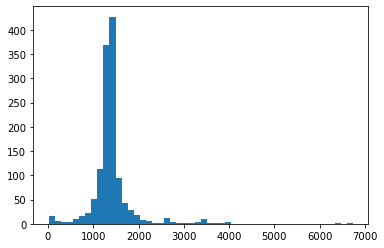

In [5]:
plt.hist(data['Description'].apply(len), bins=50)

In [6]:
len([d for d in data['Description'] if len(d)<500])

25

In [7]:
def run_experiment(sample_not_relevant_range, num_repeats, vectorizer_type,model_type = 'naive_bayes',bert_type = 'bert'):
    experiments_results = []
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type,
                bert_type = bert_type
            )
    X_vect,y = grant_tagger.transform(data)
    for n in sample_not_relevant_range:
        average_results_train = None
        average_results_test = None
        for i in range(0, num_repeats):
            # Take the average of 5 runs

            X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
            grant_tagger.fit(X_train, y_train)
            results_train = grant_tagger.evaluate(X_train, y_train, print_results=False, average='weighted')
            results_test = grant_tagger.evaluate(X_test, y_test, print_results=False, average='weighted')
            if average_results_train: # will be the same for test too
                for key in average_results_train.keys(): # will be the same for test too
                    average_results_train[key] += results_train[key]
                    average_results_test[key] += results_test[key]
            else:
                average_results_train = results_train
                average_results_test = results_test
        average_results_train = {key: value/num_repeats for key, value in average_results_train.items()}
        average_results_test = {key: value/num_repeats for key, value in average_results_test.items()}
        results_dict = {'sample_not_relevant': n}
        for key, value in average_results_train.items():
            results_dict[key+'_train'] = value
        for key, value in average_results_test.items():
            results_dict[key+'_test'] = value
        experiments_results.append(results_dict)
        
    return experiments_results

In [8]:
def plot_results(experiments_results_df):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_train',ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_test', color='red', ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_train',ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_test', color='red', ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_train',ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_test', color='red', ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_train',ax=ax4, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_test', color='red', ax=ax4, marker='.')
    # fig.savefig(f'sample_not_relevant_{num_repeats}reps_{vectorizer_type}.png')
    # plt.close(fig)
    plt.show()

In [9]:
count_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='count'
)

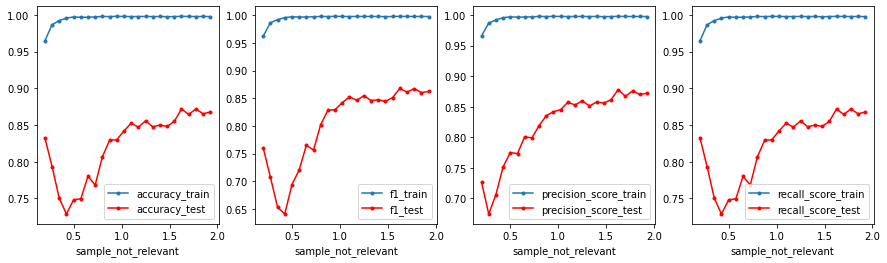

In [10]:
experiments_results_df = pd.DataFrame(count_experiments_results)
plot_results(experiments_results_df)

In [11]:
tfidf_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='tfidf'
)

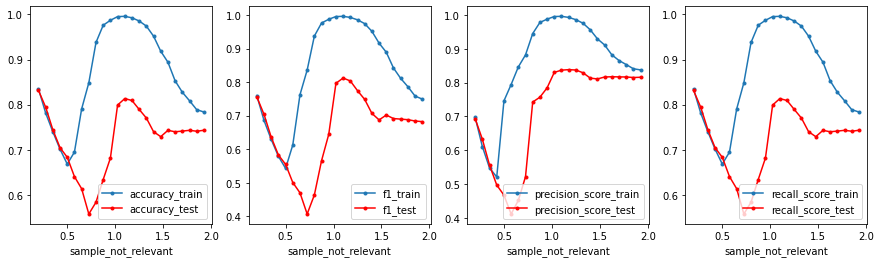

In [12]:
experiments_results_df = pd.DataFrame(tfidf_experiments_results)
plot_results(experiments_results_df)

In [13]:
print(len(data.loc[data['Relevance code'] == 1]))
print(len(data.loc[data['Relevance code'] == 0]))

292
989


## Explore all the results of those with good parameters

In [14]:
def test_setting(data, vectorizer_type, n, model_type = 'naive_bayes',bert_type = 'bert'):
    i = 4
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type,
                bert_type = bert_type
            )
    X_vect,y = grant_tagger.transform(data)
    X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
    grant_tagger.fit(X_train, y_train)
    results_train = grant_tagger.evaluate(X_train, y_train, average='weighted')
    results_test = grant_tagger.evaluate(X_test, y_test, average='weighted')

In [15]:
test_setting(data, 'tfidf', 0.2)

{'accuracy': 0.8396946564885496, 'f1': 0.7665262424376801, 'precision_score': 0.7050871161354233, 'recall_score': 0.8396946564885496}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.84      1.00      0.91       220

    accuracy                           0.84       262
   macro avg       0.42      0.50      0.46       262
weighted avg       0.71      0.84      0.77       262

              predicted tag 0  predicted tag 1
actual tag 0                0               42
actual tag 1                0              220
{'accuracy': 0.8181818181818182, 'f1': 0.7363636363636363, 'precision_score': 0.6694214876033059, 'recall_score': 0.8181818181818182}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.82      1.00      0.90        72

    accuracy                           0.82        88
   macro avg       0.41      0.50      0.45   

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
test_setting(data, 'tfidf', 1.1)

{'accuracy': 0.9978213507625272, 'f1': 0.9978215164195918, 'precision_score': 0.9978311644978313, 'recall_score': 0.9978213507625272}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       221

    accuracy                           1.00       459
   macro avg       1.00      1.00      1.00       459
weighted avg       1.00      1.00      1.00       459

              predicted tag 0  predicted tag 1
actual tag 0              237                1
actual tag 1                0              221
{'accuracy': 0.8181818181818182, 'f1': 0.8183351735983315, 'precision_score': 0.8254078071429669, 'recall_score': 0.8181818181818182}
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        83
           1       0.77      0.87      0.82        71

    accuracy                           0.82       154
   macro avg       0.82      0.82      0.82   

In [17]:
test_setting(data, 'count', 0.2)

{'accuracy': 0.9351145038167938, 'f1': 0.9280896035964299, 'precision_score': 0.9397687377202306, 'recall_score': 0.9351145038167938}
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        42
           1       0.93      1.00      0.96       220

    accuracy                           0.94       262
   macro avg       0.96      0.80      0.85       262
weighted avg       0.94      0.94      0.93       262

              predicted tag 0  predicted tag 1
actual tag 0               25               17
actual tag 1                0              220
{'accuracy': 0.8181818181818182, 'f1': 0.7363636363636363, 'precision_score': 0.6694214876033059, 'recall_score': 0.8181818181818182}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.82      1.00      0.90        72

    accuracy                           0.82        88
   macro avg       0.41      0.50      0.45   

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
test_setting(data, 'count', 1.625)

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       359
           1       1.00      1.00      1.00       215

    accuracy                           1.00       574
   macro avg       1.00      1.00      1.00       574
weighted avg       1.00      1.00      1.00       574

              predicted tag 0  predicted tag 1
actual tag 0              359                0
actual tag 1                0              215
{'accuracy': 0.8385416666666666, 'f1': 0.83254918920808, 'precision_score': 0.8496859681372548, 'recall_score': 0.8385416666666666}
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       115
           1       0.91      0.66      0.77        77

    accuracy                           0.84       192
   macro avg       0.86      0.81      0.82       192
weighted avg       0.85      0.84      0.83       192


## Testing Bert Vectorizer


Bert and Naive Bayes model


In [19]:
%%capture
bert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert'
)


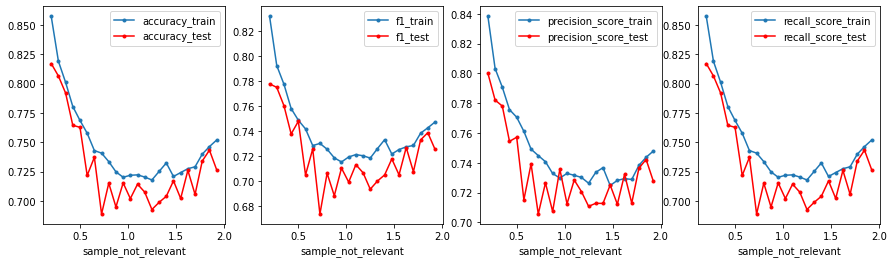

In [20]:
experiments_results_df = pd.DataFrame(bert_bayes_experiments_results)
plot_results(experiments_results_df)

Bert and SVM model


In [21]:
%%capture
bert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='SVM'
)


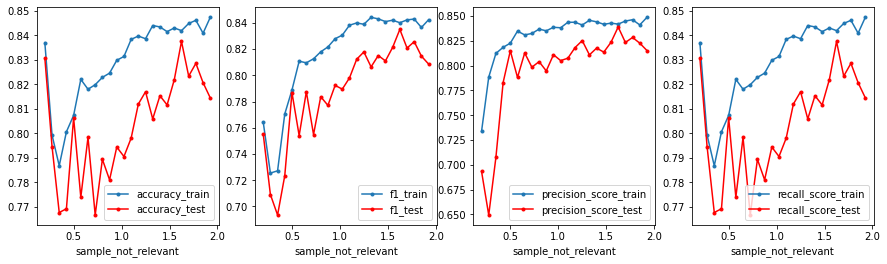

In [22]:
experiments_results_df = pd.DataFrame(bert_svm_experiments_results)
plot_results(experiments_results_df)

Bert and Logistic regression model


In [23]:
%%capture
bert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='log_reg'
)


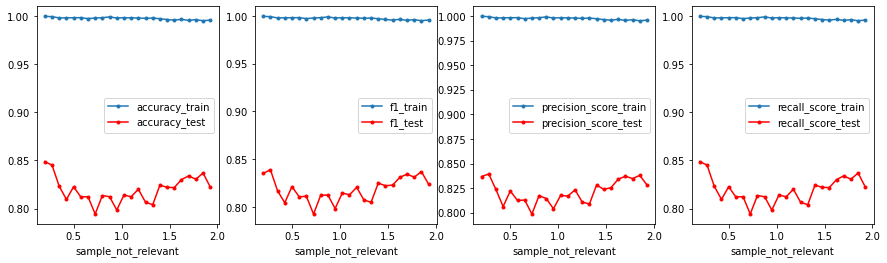

In [24]:
experiments_results_df = pd.DataFrame(bert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Bert Results with good parameters 

In [25]:
test_setting(data, 'bert', 0.2)

{'accuracy': 0.8473282442748091, 'f1': 0.7958496375649496, 'precision_score': 0.8219227099236641, 'recall_score': 0.8473282442748091}
              precision    recall  f1-score   support

           0       0.67      0.10      0.17        42
           1       0.85      0.99      0.92       220

    accuracy                           0.85       262
   macro avg       0.76      0.54      0.54       262
weighted avg       0.82      0.85      0.80       262

              predicted tag 0  predicted tag 1
actual tag 0                4               38
actual tag 1                2              218
{'accuracy': 0.8295454545454546, 'f1': 0.7623852285339521, 'precision_score': 0.8589341692789968, 'recall_score': 0.8295454545454546}
              precision    recall  f1-score   support

           0       1.00      0.06      0.12        16
           1       0.83      1.00      0.91        72

    accuracy                           0.83        88
   macro avg       0.91      0.53      0.51   

In [26]:
test_setting(data, 'bert', 1.775)

{'accuracy': 0.7693574958813838, 'f1': 0.7636485371065231, 'precision_score': 0.7645388031572, 'recall_score': 0.7693574958813838}
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       390
           1       0.72      0.59      0.65       217

    accuracy                           0.77       607
   macro avg       0.75      0.73      0.74       607
weighted avg       0.76      0.77      0.76       607

              predicted tag 0  predicted tag 1
actual tag 0              339               51
actual tag 1               89              128
{'accuracy': 0.7733990147783252, 'f1': 0.7676105691318673, 'precision_score': 0.7698798784794693, 'recall_score': 0.7733990147783252}
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       128
           1       0.74      0.60      0.66        75

    accuracy                           0.77       203
   macro avg       0.76      0.74      0.75      

In [27]:
test_setting(data, 'bert', 0.5,'SVM')

{'accuracy': 0.7804878048780488, 'f1': 0.7547838007654081, 'precision_score': 0.8042252685300576, 'recall_score': 0.7804878048780488}
              precision    recall  f1-score   support

           0       0.89      0.42      0.57       114
           1       0.76      0.97      0.85       214

    accuracy                           0.78       328
   macro avg       0.82      0.70      0.71       328
weighted avg       0.80      0.78      0.75       328

              predicted tag 0  predicted tag 1
actual tag 0               48               66
actual tag 1                6              208
{'accuracy': 0.8363636363636363, 'f1': 0.8261409273457466, 'precision_score': 0.8342975206611571, 'recall_score': 0.8363636363636363}
              precision    recall  f1-score   support

           0       0.82      0.56      0.67        32
           1       0.84      0.95      0.89        78

    accuracy                           0.84       110
   macro avg       0.83      0.76      0.78   

In [28]:
test_setting(data, 'bert', 1.625,'SVM')

{'accuracy': 0.8554006968641115, 'f1': 0.8516859398801022, 'precision_score': 0.8578514357803677, 'recall_score': 0.8554006968641115}
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       359
           1       0.88      0.71      0.79       215

    accuracy                           0.86       574
   macro avg       0.86      0.83      0.84       574
weighted avg       0.86      0.86      0.85       574

              predicted tag 0  predicted tag 1
actual tag 0              338               21
actual tag 1               62              153
{'accuracy': 0.7708333333333334, 'f1': 0.7659494535519126, 'precision_score': 0.7698643410852714, 'recall_score': 0.7708333333333334}
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       115
           1       0.76      0.62      0.69        77

    accuracy                           0.77       192
   macro avg       0.77      0.75      0.75   

## Testing Scibert Vectorizer


Scibert and Naive Bayes model


In [29]:
%%capture
scibert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', bert_type= 'scibert'
)


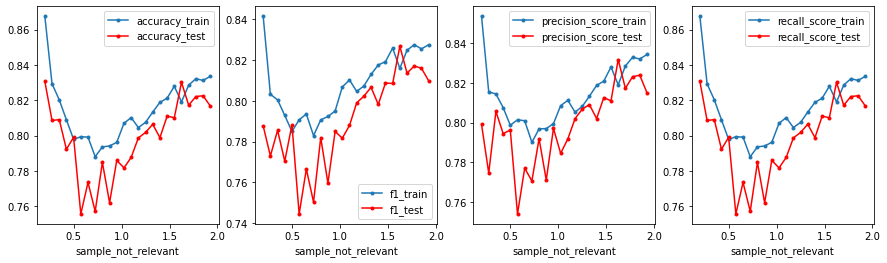

In [30]:
experiments_results_df = pd.DataFrame(scibert_bayes_experiments_results)
plot_results(experiments_results_df)

Scibert and SVM model


In [31]:
%%capture
scibert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='SVM', bert_type= 'scibert'
)


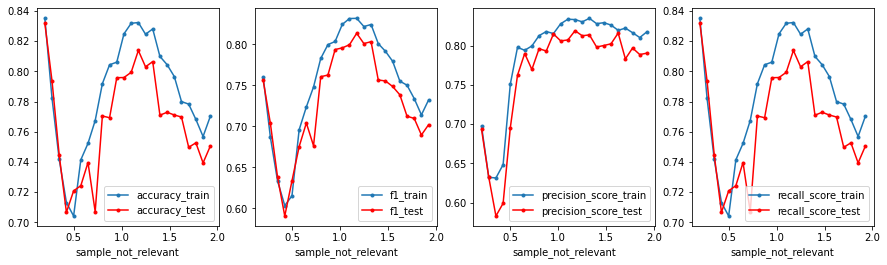

In [32]:
experiments_results_df = pd.DataFrame(scibert_svm_experiments_results)
plot_results(experiments_results_df)

Scibert and Logistic regression model


In [33]:
%%capture
scibert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='bert', model_type='log_reg', bert_type= 'scibert'
)


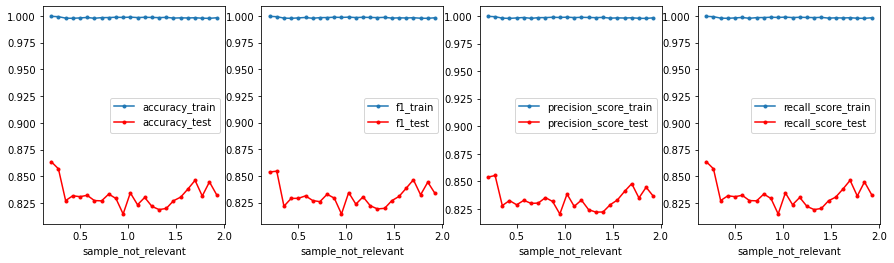

In [35]:
experiments_results_df = pd.DataFrame(scibert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Scibert Results with good parameters

Scibert and Naive Bayes

In [ ]:
test_setting(data, 'bert', 1.625, bert_type = 'scibert')

Scibert and SVM

In [ ]:
test_setting(data, 'bert', 0.2, 'SVM',bert_type = 'scibert')

In [ ]:
test_setting(data, 'bert', 1.175,'SVM', bert_type = 'scibert')

Scibert and log reg

In [ ]:
test_setting(data, 'bert', 0.275,'log_reg', bert_type = 'scibert')

In [ ]:
test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

Scibert and Naive Bayes

In [37]:
test_setting(data, 'bert', 1.625, bert_type = 'scibert')

{'accuracy': 0.8466898954703833, 'f1': 0.8415942676813987, 'precision_score': 0.8513547596975352, 'recall_score': 0.8466898954703833}
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       359
           1       0.88      0.68      0.77       215

    accuracy                           0.85       574
   macro avg       0.86      0.81      0.83       574
weighted avg       0.85      0.85      0.84       574

              predicted tag 0  predicted tag 1
actual tag 0              340               19
actual tag 1               69              146
{'accuracy': 0.7916666666666666, 'f1': 0.7854403858317519, 'precision_score': 0.794629582430653, 'recall_score': 0.7916666666666666}
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       115
           1       0.81      0.62      0.71        77

    accuracy                           0.79       192
   macro avg       0.80      0.76      0.77    

Scibert and SVM

In [41]:
test_setting(data, 'bert', 0.2, 'SVM',bert_type = 'scibert')

{'accuracy': 0.8396946564885496, 'f1': 0.7665262424376801, 'precision_score': 0.7050871161354233, 'recall_score': 0.8396946564885496}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.84      1.00      0.91       220

    accuracy                           0.84       262
   macro avg       0.42      0.50      0.46       262
weighted avg       0.71      0.84      0.77       262

              predicted tag 0  predicted tag 1
actual tag 0                0               42
actual tag 1                0              220
{'accuracy': 0.8181818181818182, 'f1': 0.7363636363636363, 'precision_score': 0.6694214876033059, 'recall_score': 0.8181818181818182}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.82      1.00      0.90        72

    accuracy                           0.82        88
   macro avg       0.41      0.50      0.45   

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
test_setting(data, 'bert', 1.175,'SVM', bert_type = 'scibert')

{'accuracy': 0.8445378151260504, 'f1': 0.8432232906171068, 'precision_score': 0.8471177088721668, 'recall_score': 0.8445378151260504}
              precision    recall  f1-score   support

           0       0.83      0.91      0.86       261
           1       0.87      0.77      0.82       215

    accuracy                           0.84       476
   macro avg       0.85      0.84      0.84       476
weighted avg       0.85      0.84      0.84       476

              predicted tag 0  predicted tag 1
actual tag 0              237               24
actual tag 1               50              165
{'accuracy': 0.7861635220125787, 'f1': 0.7818271236108221, 'precision_score': 0.8040124358250417, 'recall_score': 0.7861635220125787}
              precision    recall  f1-score   support

           0       0.74      0.91      0.82        82
           1       0.88      0.65      0.75        77

    accuracy                           0.79       159
   macro avg       0.81      0.78      0.78   

Scibert and log reg

In [43]:
test_setting(data, 'bert', 0.275,'log_reg', bert_type = 'scibert')

{'accuracy': 1.0, 'f1': 1.0, 'precision_score': 1.0, 'recall_score': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00       218

    accuracy                           1.00       279
   macro avg       1.00      1.00      1.00       279
weighted avg       1.00      1.00      1.00       279

              predicted tag 0  predicted tag 1
actual tag 0               61                0
actual tag 1                0              218
{'accuracy': 0.8924731182795699, 'f1': 0.8844871526323139, 'precision_score': 0.8889991728701407, 'recall_score': 0.8924731182795699}
              precision    recall  f1-score   support

           0       0.85      0.58      0.69        19
           1       0.90      0.97      0.94        74

    accuracy                           0.89        93
   macro avg       0.87      0.78      0.81        93
weighted avg       0.89      0.89      0.88        9

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [44]:
test_setting(data, 'bert', 1.7,'log_reg', bert_type = 'scibert')

{'accuracy': 0.9983079526226735, 'f1': 0.9983071282949767, 'precision_score': 0.9983124647490129, 'recall_score': 0.9983079526226735}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       217

    accuracy                           1.00       591
   macro avg       1.00      1.00      1.00       591
weighted avg       1.00      1.00      1.00       591

              predicted tag 0  predicted tag 1
actual tag 0              374                0
actual tag 1                1              216
{'accuracy': 0.8477157360406091, 'f1': 0.8484244182213726, 'precision_score': 0.8498481295815694, 'recall_score': 0.8477157360406091}
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       122
           1       0.78      0.83      0.81        75

    accuracy                           0.85       197
   macro avg       0.84      0.84      0.84   

c:\users\nonie\documents\wellcome\nutrition-labels\venv\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
